In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
from scipy.optimize import curve_fit
import seaborn as sns
sns.set()
sns.set_style("white")
sns.set_style("ticks")

In [2]:
#load data
histos = np.load("AllDAta.bin.npy")
gOne = np.load("alldataG1.npy")
gOneTot = np.load("GOneTot.npy")

In [3]:
#define needed functions
def fitSinus(x, a, b, c, d):
    return a*np.sin(b*(x+c))+d

def getSameChannels(histo, detector=0):
    len = histo.shape[1]
    out = np.zeros((len, histo.shape[3]), dtype=np.int32)
    for i in range(len):
        out[i] = histo[detector][i][i]
    return out

def getCrossChannels(histo, startChannel, detector=0):
    len = histo.shape[1]
    out = np.zeros((len, histo.shape[3]), dtype=np.int32)
    for i in range(len):
        out[i] = histo[detector][startChannel][i]
    return out

def fittingFuntion(x, a, b, c, d, e):
    return (a**2/(a+d*np.cos(b*(x+c)))**2)-e

def anti_bunching_fit(x, a, b, c, d, e):
    #a = 0.78
    #b = 129.87e6
    #c = 235e6
    #d = b/c
    #d = 0
    #return 1-a*np.exp(-b*x)*(np.cos(c*x)+(b/c)*np.sin(c*x))
    x = np.abs(x-d)
    return e*1.0-a*np.exp(-b*(x))*(np.cos(c*(x)))

def spatialoFunc(x, x0, spatMod, offsetx, offsety, sat, dwf, loss=1):
    return (((sat**2)*np.cos((spatMod*(x-offsetx)-x0)/2)**2*dwf*loss)/((sat+np.cos(x0)*dwf)*(sat+np.cos(spatMod*(x-offsetx))*dwf))) + offsety

def getTimeSlice(histos, startingDet, gOne, getRaw=False):
    timeScale = 2.5 * 1e-9
    # do 2d Plot of spatio temporal regime
    bins = np.arange(-40e-9, 50e-9, timeScale)
    histoNow, histAcc = histos
    histoMaster = getCrossChannels(histAcc, startingDet, 0)
    histoSlave = getCrossChannels(histAcc, startingDet, 1)
    binDurationMaster = 23.616e-12
    binDurationSlave = 22.22e-12
    offsetMaster = 1559
    offsetSlave = 1591
    mergedImag = np.zeros((histoMaster.shape[0], len(bins) - 1), dtype=np.float64)
    for i in range(histoMaster.shape[0]):
        singleHistoMaster = histoMaster[i]
        singleHistoSlave = histoSlave[i]
        valsNeeded = []
        for j in range(4096):
            timeMaster = float((j - offsetMaster)) * binDurationMaster
            timeSlave = float((j - offsetSlave)) * binDurationSlave
            # append for master
            valsNeeded.append([timeMaster] * singleHistoMaster[j])
            # append for slave
            valsNeeded.append([timeSlave] * singleHistoSlave[j])
        # ravel
        flat_list = [item for sublist in valsNeeded for item in sublist]
        ravelled = np.array(flat_list)
        histo = np.histogram(ravelled, bins)
        # add column to imag
        mergedImag[i] = histo[0]
    # got histos, create imag
    # jup
    # copy normalization one
    normedImag = mergedImag
    # transpose imag
    mergedImag = mergedImag.T
    # normalize
    imagBinnedMaster, imagBinnedSlave = gOne
    totaloBinned = np.add(imagBinnedSlave[1], imagBinnedMaster[1])
    totaloBinned = totaloBinned / np.sum(totaloBinned)
    newNormalized = np.zeros_like(normedImag)
    errorsRelative = np.zeros(normedImag.shape[0], dtype=np.float64)
    zeroBin = int(mergedImag.shape[0] / 2) - 1
    for i in range(normedImag.shape[0]):
        if (normedImag[i][zeroBin] != 0):
            errorsRelative[i] = (np.sqrt(normedImag[i][zeroBin]) / normedImag[i][zeroBin])
        newNormalized[i] = normedImag[i] / (totaloBinned[i] * totaloBinned[startingDet])
    finishedNormalied = newNormalized.T
    perBin = float(np.sum(mergedImag)) / float(mergedImag.shape[0] * mergedImag.shape[1])
        
    #adding gettting raw output from this thing
    if (getRaw):
        return mergedImag, errorsRelative
    
    return finishedNormalied, errorsRelative

def errorModel(x, a):
    val = (a * (1./(np.sqrt(x))))
    return val

def freeExponent(x, a, b):
    val = (a * (np.power(x, b)))
    return val

<IPython.core.display.Javascript object>


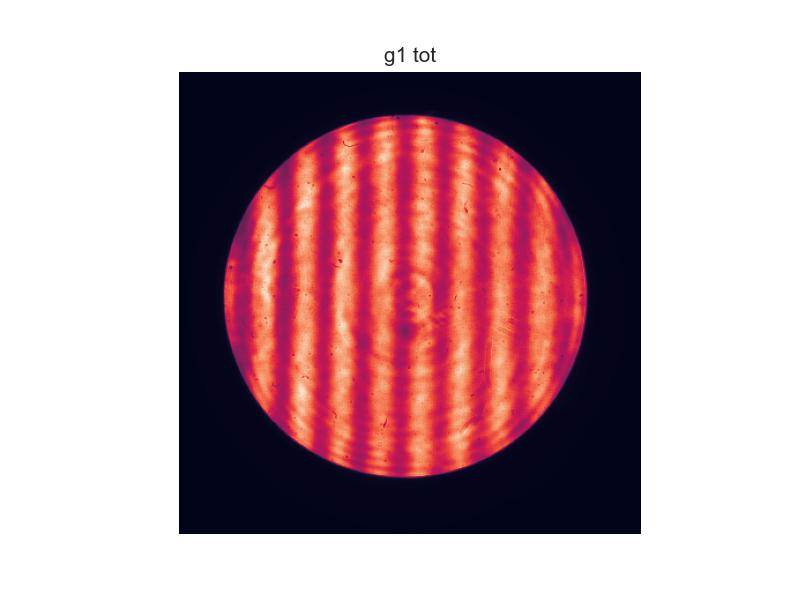

In [4]:
#quick look
plt.figure()
plt.axis('off')
plt.grid(False)
plt.imshow(gOneTot[0])
plt.title("g1 tot")
plt.show()
plt.show()

<IPython.core.display.Javascript object>


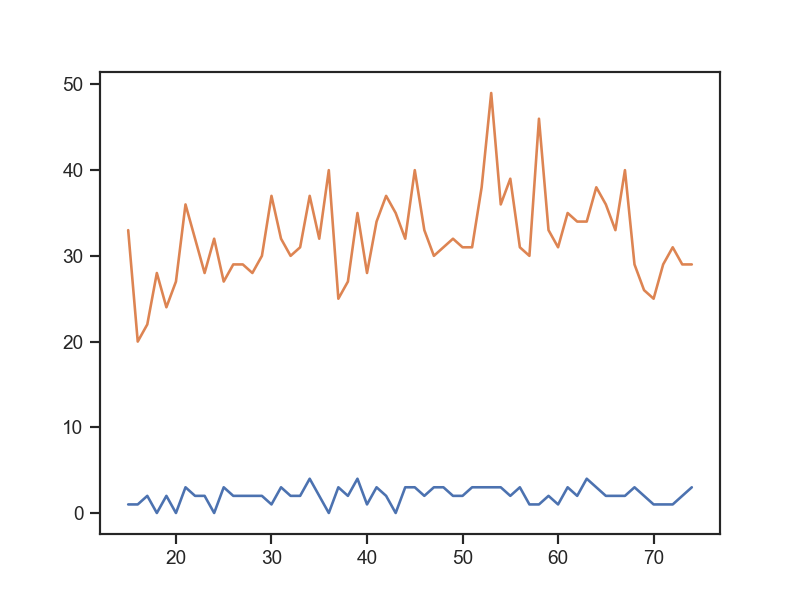

In [5]:
#plot max and minimum coicicendences according to starting detector
startOne = 15
endOne = 75

maxa = []
mina = []

for i in range(startOne, endOne):
    temporalSlice, errors = np.array(getTimeSlice(histos, int(i), gOne, True))
    sliced = temporalSlice[int(temporalSlice.shape[0]/2)-1][startOne:endOne]
    maxa.append(np.amax(sliced))
    mina.append(np.amin(sliced))
    


#prepare and bin raw data
sliced, errors = getTimeSlice(histos, 41, gOne, True)
plt.figure()
plt.plot(range(startOne, endOne), mina)
plt.plot(range(startOne, endOne), maxa)
plt.show()

<IPython.core.display.Javascript object>


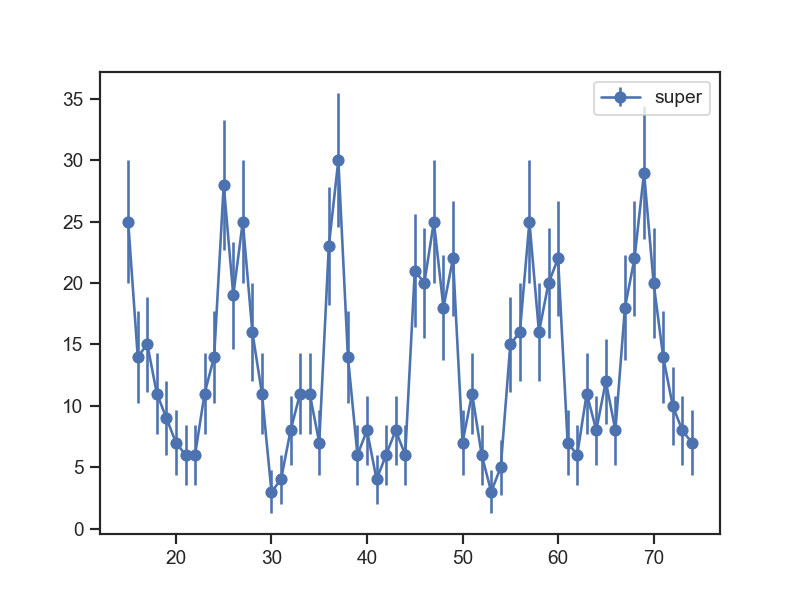

MeanVal (Counts): 15.4
MeanVal (Counts): 13.3


In [6]:
#pick a nice signal, aka a subradiant and superradiant starting detector position
startOne = 15
endOne = 75

superRadiantDet = 47
subRadiantDet = 41
plt.figure()

temporalSlice, Errors = np.array(getTimeSlice(histos, subRadiantDet, gOne, True))
sliced = temporalSlice[int(temporalSlice.shape[0]/2)-1][startOne:endOne]
#plt.errorbar(range(startOne, endOne), sliced,  yerr=np.sqrt(sliced), fmt="o-", label="sub")

print("MeanVal (Counts): " + str(np.mean(sliced)))

temporalSlice, Errors = np.array(getTimeSlice(histos, superRadiantDet, gOne, True))
sliced = temporalSlice[int(temporalSlice.shape[0]/2)-1][startOne:endOne]
plt.errorbar(range(startOne, endOne), sliced, yerr=np.sqrt(sliced), fmt="o-", label="super")

plt.legend(loc="best")

plt.show()


print("MeanVal (Counts): " + str(np.mean(sliced)))

<ipython-input-7-5b3be3bcf4c9>:27: RuntimeWarning: invalid value encountered in true_divide
  relativeErrorsSuper = np.divide(np.sqrt(superRadiantVals), superRadiantVals)
<ipython-input-7-5b3be3bcf4c9>:28: RuntimeWarning: invalid value encountered in true_divide
  relativeErrorsSub = np.divide(np.sqrt(subRadiantVals), subRadiantVals)


<IPython.core.display.Javascript object>


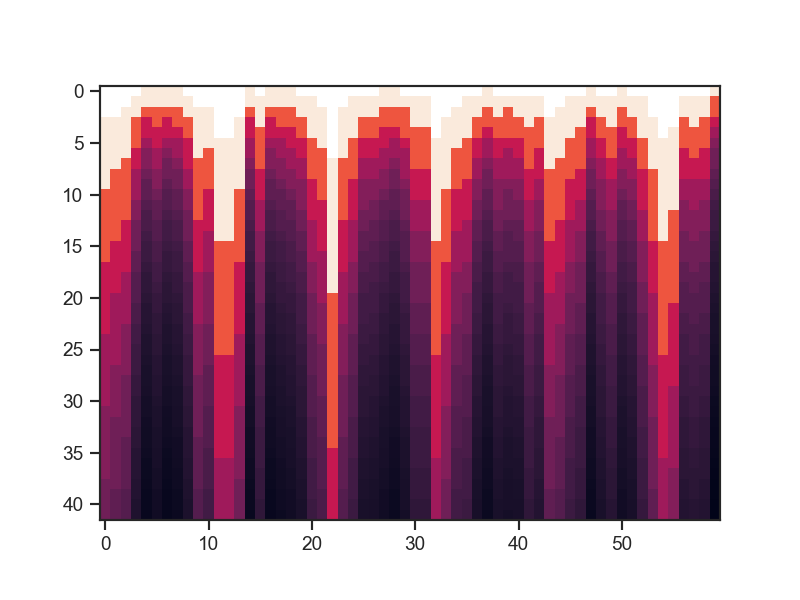

<IPython.core.display.Javascript object>


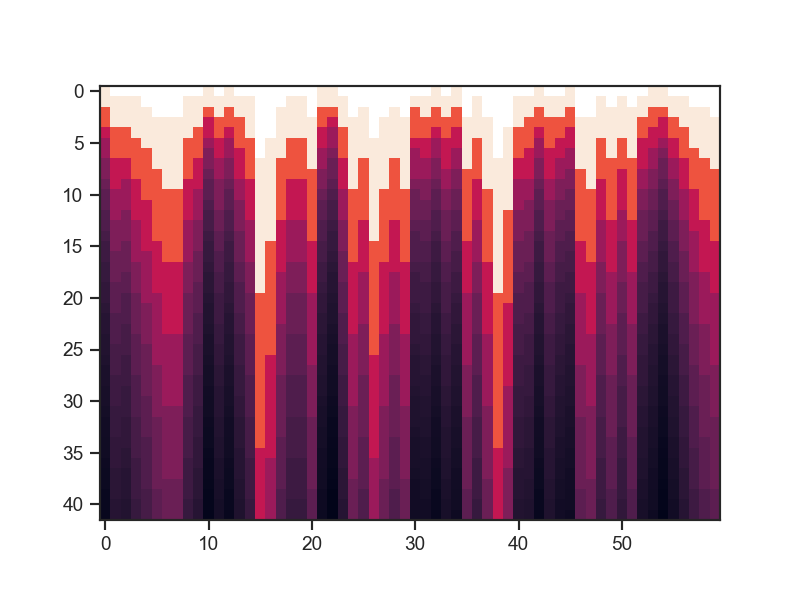

In [7]:
#create relative errors for different timing interpolations
#define region of interest, as far outside detector positions are quite dim
startOne = 15
endOne = 75
#select to according start and stop detectors
superRadiantDet = 47
subRadiantDet = 41
#measruement time was 6 weeks approx. --> calculate days for daywise error signal
duration = 6*7*1
#create numpy saving arrays with errors
superRadiantRelativeErrors = np.zeros((duration, (endOne-startOne)), dtype=np.float)
subRadiantRelativeErrors = np.zeros((duration, (endOne-startOne)), dtype=np.float)

#do an approximation for every day
for i in range(duration):
    approxFactor = ((i+1)/duration)
    
    temporalSlice, Errors = np.array(getTimeSlice(histos, superRadiantDet, gOne, True))
    superRadiantVals = temporalSlice[int(temporalSlice.shape[0]/2)-1][startOne:endOne]
    
    temporalSlice, Errors = np.array(getTimeSlice(histos, subRadiantDet, gOne, True))
    subRadiantVals = temporalSlice[int(temporalSlice.shape[0]/2)-1][startOne:endOne]
    
    superRadiantVals = np.rint(np.array(superRadiantVals, dtype=np.float)*approxFactor)
    subRadiantVals = np.rint(np.array(subRadiantVals, dtype=np.float)*approxFactor)
    
    relativeErrorsSuper = np.divide(np.sqrt(superRadiantVals), superRadiantVals)
    relativeErrorsSub = np.divide(np.sqrt(subRadiantVals), subRadiantVals)
    
    superRadiantRelativeErrors[i] = relativeErrorsSuper
    subRadiantRelativeErrors[i] = relativeErrorsSub
    
plt.figure()
plt.imshow(subRadiantRelativeErrors)
plt.show()

plt.figure()
plt.imshow(superRadiantRelativeErrors)
plt.show()
    

<IPython.core.display.Javascript object>


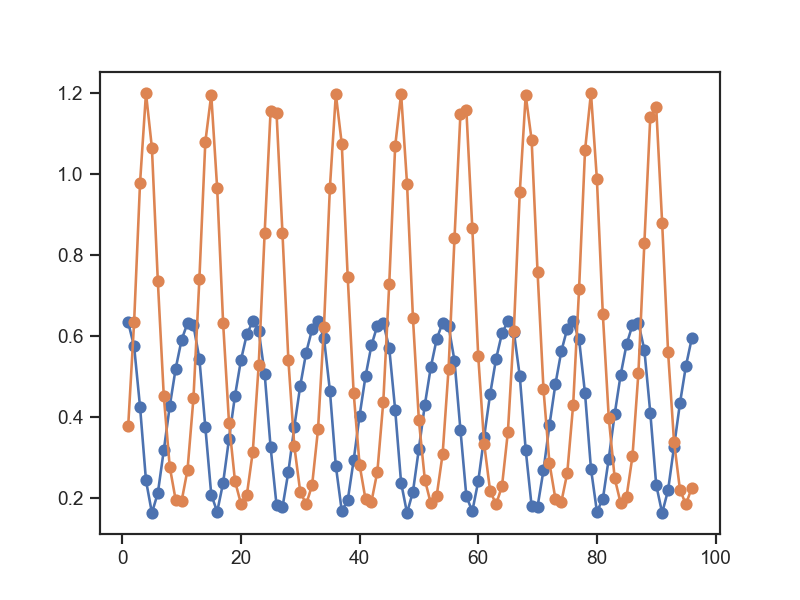

In [8]:
#sample idealized values
idealValsSuper = [-3.06284156, 0.58840339, 9.41321773, 0.18303779, 1.87720429, 0.75025119, 0.4917744 ]
idealValsSub = [6.9528108, 0.58500625, 9.27166481, 0.16166162, 1.93754741, 0.68502284, 1.07132704]
samplingVals = np.array(range(96))+1

plt.figure()
plt.plot(samplingVals, spatialoFunc(samplingVals, *idealValsSub), "o-")
plt.plot(samplingVals, spatialoFunc(samplingVals, *idealValsSuper), "o-")
plt.show()

<IPython.core.display.Javascript object>


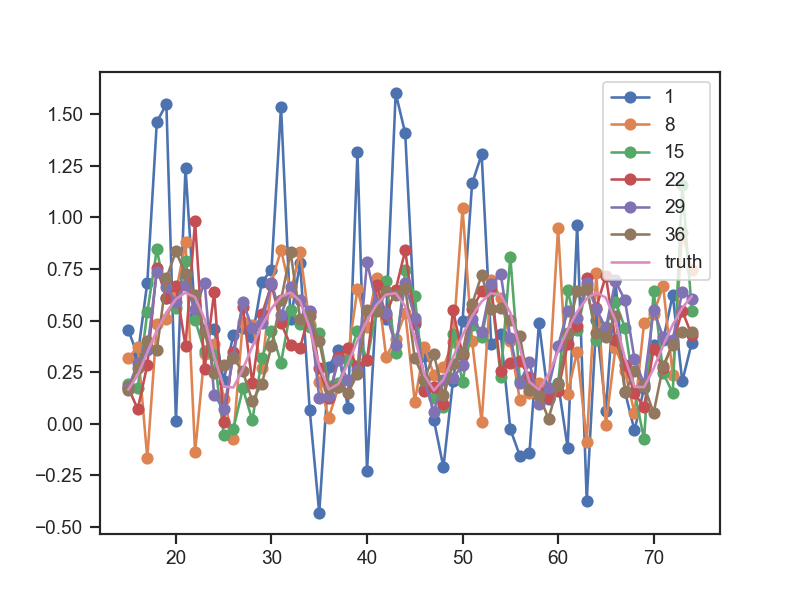

Fit failed on day 5


<IPython.core.display.Javascript object>


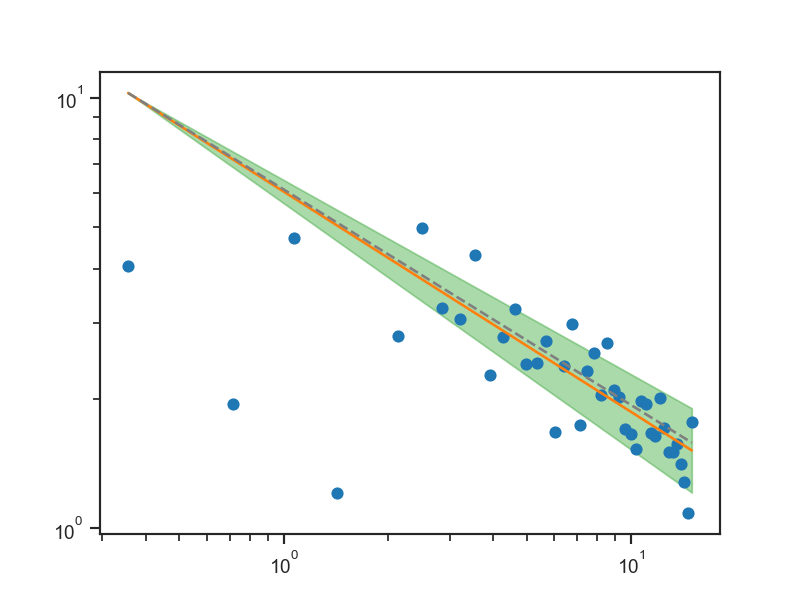

Exponent: -0.5110835677227221 \pm 0.06031410419378769


In [9]:
#sample idealized values
idealValsSuper = [-3.06284156, 0.58840339, 9.41321773, 0.18303779, 1.87720429, 0.75025119, 0.4917744 ]
idealValsSub = [6.9528108, 0.58500625, 9.27166481, 0.16166162, 1.93754741, 0.68502284, 1.07132704]
samplingVals = np.array(range(96))+1
#then do error progression and fit
startOne = 15
endOne = 75
#select to according start and stop detectors
superRadiantDet = 47
subRadiantDet = 41

np.random.seed(0)

#------ go
SampledIdealValsSuper = spatialoFunc(samplingVals, *idealValsSuper)
SampledIdealValsSub = spatialoFunc(samplingVals, *idealValsSub)

#maybe start with sub values as they seem more stable
#do iteration over any day
feasibleDays = []
frequencyFitError = []
spatFreq = []

plt.figure()

for i in range(subRadiantRelativeErrors.shape[0]):
    errors = subRadiantRelativeErrors[i]
    temporalSample = SampledIdealValsSub[startOne:endOne]
    xes = np.array(range(len(SampledIdealValsSub)))[startOne:endOne]
    #if we got nans in the errors, then there is no coincidence in the array, skip this day
    if (np.isnan(errors).any()):
        #continue
        errors = np.ones_like(errors)
    
    zeros = np.zeros(endOne-startOne)
    #now draw accordingrandomNumbers
    randoms = []
    for j in range(len(zeros)):
        randoms.append(np.random.normal(0.0, temporalSample[j]*errors[j]))
    
    startingVals = idealValsSub
    
    newVals = temporalSample + randoms
    try:
        popt, pcov = curve_fit(spatialoFunc, xes, newVals, p0=startingVals)
        feasibleDays.append(i+1)
        frequencyFitError.append(np.sqrt(pcov[1][1])/popt[1])
        spatFreq.append(popt[1])
        if (i%7 == 0):
            plt.plot(xes, newVals, "o-", label=str(i+1))
        
    except RuntimeError:
        print("Fit failed on day " + str(i+1))

        
plt.plot(xes, SampledIdealValsSub[startOne:endOne], label="truth")
plt.legend(loc="best")
plt.show()
    
feasibleDays = np.array(feasibleDays)    
fittingFeasibleDays = feasibleDays[6:]

deltaSpatialFreqOnLastDay = 1.7707518921594856
normalizer = deltaSpatialFreqOnLastDay/frequencyFitError[-1]

frequencyFitError = np.array(frequencyFitError) * normalizer

popt, pcov = curve_fit(freeExponent, fittingFeasibleDays, frequencyFitError[6:], p0=[0.007, -0.5])

plt.figure()

a = popt[0]
b = popt[1]
err_b = np.sqrt(pcov[1][1])

xes = 14.96 * (feasibleDays/np.amax(feasibleDays))

plt.fill_between(xes, freeExponent(feasibleDays, *[a, b + err_b]), freeExponent(feasibleDays, *[a, b - err_b]), color="tab:green", alpha=0.4)
plt.plot(xes, frequencyFitError, "o", label="error", color="tab:blue")
plt.plot(xes, freeExponent(feasibleDays, *popt), label="fit",  color="tab:orange")
plt.plot(xes, errorModel(feasibleDays, popt[0]), "--", label="sqrt",  color="tab:grey")
plt.yscale("log")
plt.xscale("log")
#plt.plot(feasibleDays, spatFreq, label="spatial freq.")
#plt.legend(loc="best")
#plt.show()
plt.savefig("errorOverTime.pdf")

print("Exponent: " + str(b) + " \pm " + str(err_b))

<ipython-input-10-5d6300439de9>:4: RuntimeWarning: invalid value encountered in sqrt
  yes = 3*(1/np.sqrt(xes - 2))


<IPython.core.display.Javascript object>


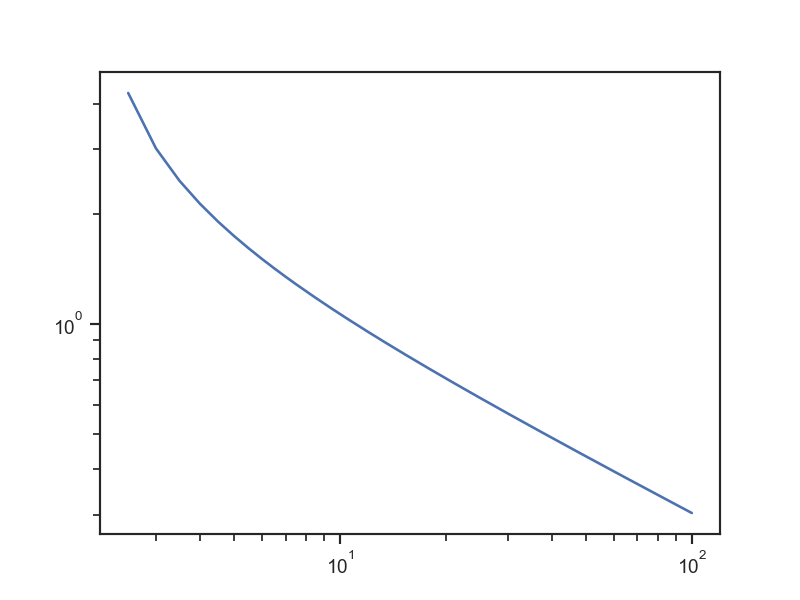

In [10]:
#powerlaw test

xes = np.linspace(1., 100., num=200)
yes = 3*(1/np.sqrt(xes - 2))

plt.figure()
plt.plot(xes, yes, label="fit")
plt.yscale("log")
plt.xscale("log")
plt.show()